In [1]:
%matplotlib inline
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import date , datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import ta
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Dense,LSTM,Dropout,Conv2D,Conv1D,MaxPool1D,MaxPool2D,Flatten,BatchNormalization,Bidirectional,TimeDistributed,add,Input,GlobalAveragePooling2D,ReLU,SimpleRNN,concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from sklearn.metrics import mean_squared_error

In [2]:
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

## Download data

In [3]:
# tickers = ['IBM']
# for ticker in tickers:
#     os.makedirs(f'data/{ticker}', exist_ok=True) 
#     data = yf.download(ticker,start="2010-01-01", end="2021-01-01")
#     data.to_csv(f'data/{ticker}/{ticker}.csv')

## Define Technical Indicators

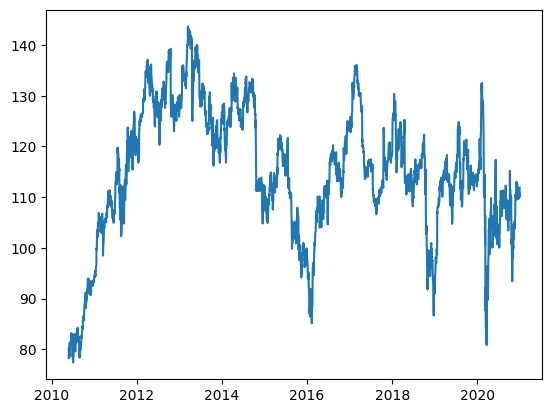

In [4]:
ibm = pd.read_csv('data/IBM/IBM.csv',index_col='Date', parse_dates=True).astype(float)
ibm['Close'] = ibm['Adj Close']
ibm = ibm.drop('Adj Close',axis = 1)

ibm['rsi_5'] = ta.momentum.RSIIndicator(ibm['Close'],window=5,fillna=True).rsi()
ibm['rsi_15'] = ta.momentum.RSIIndicator(ibm['Close'],window=15,fillna=True).rsi()
ibm['rsi_20'] = ta.momentum.RSIIndicator(ibm['Close'],window=20,fillna=True).rsi()
ibm['rsi_30'] = ta.momentum.RSIIndicator(ibm['Close'],window=30,fillna=True).rsi()
ibm['rsi_50'] = ta.momentum.RSIIndicator(ibm['Close'],window=50,fillna=True).rsi()
ibm['rsi_100'] = ta.momentum.RSIIndicator(ibm['Close'],window=100,fillna=True).rsi()

ibm['ema_5']=ta.trend.ema_indicator(ibm['Close'],window=5,fillna=True)
ibm['ema_15']=ta.trend.ema_indicator(ibm['Close'],window=15,fillna=True)
ibm['ema_20']=ta.trend.ema_indicator(ibm['Close'],window=20,fillna=True)
ibm['ema_30']=ta.trend.ema_indicator(ibm['Close'],window=30,fillna=True)
ibm['ema_50']=ta.trend.ema_indicator(ibm['Close'],window=50,fillna=True)
ibm['ema_100']=ta.trend.ema_indicator(ibm['Close'],window=100,fillna=True)

ibm['william_5']=ta.momentum.williams_r(ibm['High'],ibm['Low'],ibm['Close'],lbp=5,fillna=True)
ibm['william_15']=ta.momentum.williams_r(ibm['High'],ibm['Low'],ibm['Close'],lbp=15,fillna=True)
ibm['william_20']=ta.momentum.williams_r(ibm['High'],ibm['Low'],ibm['Close'],lbp=20,fillna=True)
ibm['william_30']=ta.momentum.williams_r(ibm['High'],ibm['Low'],ibm['Close'],lbp=30,fillna=True)

ibm['mfi_5']=ta.volume.MFIIndicator(ibm['High'],ibm['Low'],ibm['Close'],ibm['Volume'],window=5,fillna=True).money_flow_index()
ibm['mfi_15']=ta.volume.MFIIndicator(ibm['High'],ibm['Low'],ibm['Close'],ibm['Volume'],window=15,fillna=True).money_flow_index()
ibm['mfi_20']=ta.volume.MFIIndicator(ibm['High'],ibm['Low'],ibm['Close'],ibm['Volume'],window=20,fillna=True).money_flow_index()
ibm['mfi_30']=ta.volume.MFIIndicator(ibm['High'],ibm['Low'],ibm['Close'],ibm['Volume'],window=30,fillna=True).money_flow_index()
ibm['mfi_50']=ta.volume.MFIIndicator(ibm['High'],ibm['Low'],ibm['Close'],ibm['Volume'],window=50,fillna=True).money_flow_index()
ibm['mfi_100']=ta.volume.MFIIndicator(ibm['High'],ibm['Low'],ibm['Close'],ibm['Volume'],window=100,fillna=True).money_flow_index()

ibm['macd_1']=ta.trend.MACD(ibm['Close'],window_fast=5,window_slow=15,window_sign=3,fillna=True).macd_diff()
ibm['macd_2']=ta.trend.MACD(ibm['Close'],window_fast=15,window_slow=20,window_sign=5,fillna=True).macd_diff()
ibm['macd_3']=ta.trend.MACD(ibm['Close'],window_fast=20,window_slow=30,window_sign=15,fillna=True).macd_diff()
ibm['macd_4']=ta.trend.MACD(ibm['Close'],window_fast=30,window_slow=50,window_sign=15,fillna=True).macd_diff()
ibm['macd_5']=ta.trend.MACD(ibm['Close'],window_fast=50,window_slow=100,window_sign=30,fillna=True).macd_diff()
ibm = ibm[100:]
plt.plot(ibm['Close'],label='Real Prices')

## Scale Dataframe

In [5]:
errors = {}
price_scaler = MinMaxScaler()

ibm['Close']=price_scaler.fit_transform(ibm['Close'].values.reshape(-1,1))


for column in ibm.columns:
    if column == 'Close' or column == 'return':
        continue
    else:
        ibm[column] = MinMaxScaler().fit_transform(ibm[column].values.reshape(-1,1))

In [6]:
future_pred = 10

## RNN

In [7]:
x = []
y = []
for i in range(32, len(ibm.values)-future_pred):
    x.append(ibm.values[i - 32:i, 0:ibm.shape[1]])
    y.append(ibm.values[i:i+future_pred, 3])

x , y = np.array(x),np.array(y)

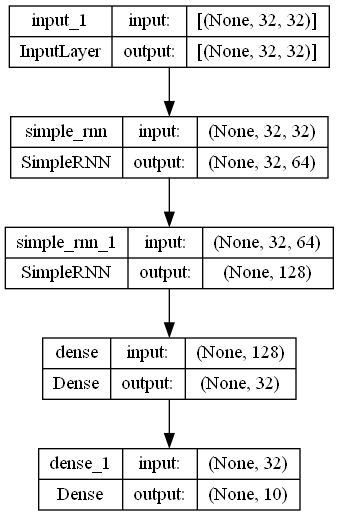

In [8]:
model = Sequential([
    Input(shape=(x.shape[1],x.shape[2])),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(128, return_sequences=False),
    Dense(32,activation='relu'),
    Dense(future_pred)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00002,
),
    loss='mse',
)
plot_model(model, show_shapes=True, to_file='simple_rnn.png')

In [9]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5,min_delta=0.001)
history = model.fit(x[:-1],y[:-1],
                    validation_split = 0.1,
                    epochs=150,
                    shuffle=False,
                    verbose=0,
                    workers=-1,
                    callbacks=[
                        earlystopping,
                    ],
                   )

Epoch 30: early stopping


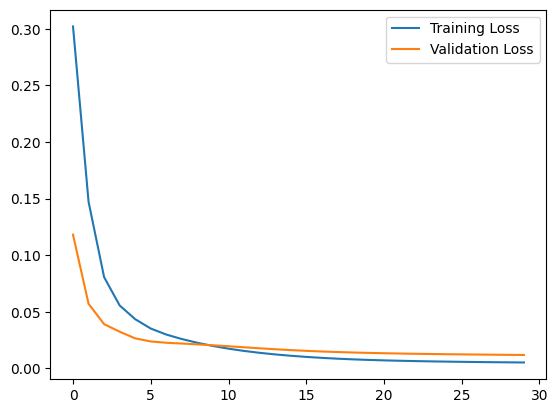

In [10]:
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()

1/1 [==============================] - 0s 243ms/step


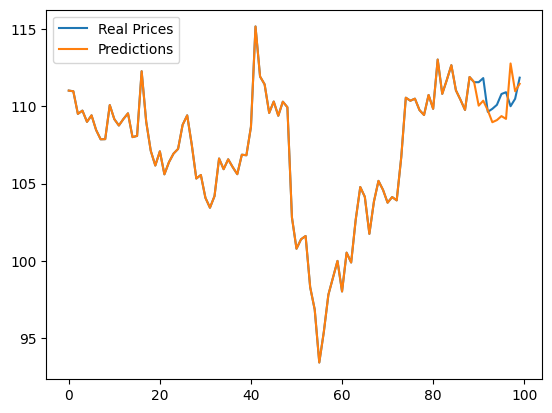

In [11]:
predictions=price_scaler.inverse_transform(model.predict(x[-1].reshape(-1, 32, 32, 1)))
real_closes = price_scaler.inverse_transform(ibm['Close'].values.reshape(-1,1))
plt.plot(real_closes[-100:],label='Real Prices')
plt.plot(np.append(real_closes[-100:-future_pred],predictions),label='Predictions')
plt.legend()

In [12]:
error = mean_squared_error(predictions.reshape(-1,1),real_closes[-future_pred:])
errors['Simple RNN'] = error
error

1.927469214732982

## 2D-CNN

In [13]:
x = []
y = []
for i in range(32, len(ibm.values)-future_pred):
    x.append(ibm.values[i - 32:i, 0:ibm.shape[1]])
    y.append(ibm.values[i:i+future_pred, 3])
x , y = np.array(x),np.array(y)

In [14]:
model = Sequential([
    Conv2D(8,3,activation='relu',input_shape=(x.shape[1],x.shape[2],1)),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(8,3,activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(32,activation='relu'),
    Dense(future_pred)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00002,
),
    loss='mse',
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 8)          0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 6, 6, 8)           0         
                                                                 
 flatten (Flatten)           (None, 288)              

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10,min_delta=0.001)
history = model.fit(x[:-1],y[:-1],
                    validation_split = 0.1,
                    epochs=200,
                    shuffle=False,
                    verbose=1,
                    callbacks=[
                        earlystopping,
                    ],
                    workers=-1
                   )

Epoch 1/200
74/74 [==============================] - 1s 8ms/step - loss: 0.3723 - val_loss: 0.1985
Epoch 2/200
74/74 [==============================] - 0s 7ms/step - loss: 0.3083 - val_loss: 0.1554
Epoch 3/200
74/74 [==============================] - 0s 7ms/step - loss: 0.2425 - val_loss: 0.1068
Epoch 4/200
74/74 [==============================] - 0s 7ms/step - loss: 0.1626 - val_loss: 0.0707
Epoch 5/200
74/74 [==============================] - 1s 7ms/step - loss: 0.1116 - val_loss: 0.0650
Epoch 6/200
74/74 [==============================] - 1s 7ms/step - loss: 0.0916 - val_loss: 0.0629
Epoch 7/200
74/74 [==============================] - 1s 7ms/step - loss: 0.0779 - val_loss: 0.0540
Epoch 8/200
74/74 [==============================] - 1s 7ms/step - loss: 0.0651 - val_loss: 0.0450
Epoch 9/200
74/74 [==============================] - 1s 7ms/step - loss: 0.0532 - val_loss: 0.0390
Epoch 10/200
74/74 [==============================] - 1s 7ms/step - loss: 0.0450 - val_loss: 0.0357
Epoch 11/

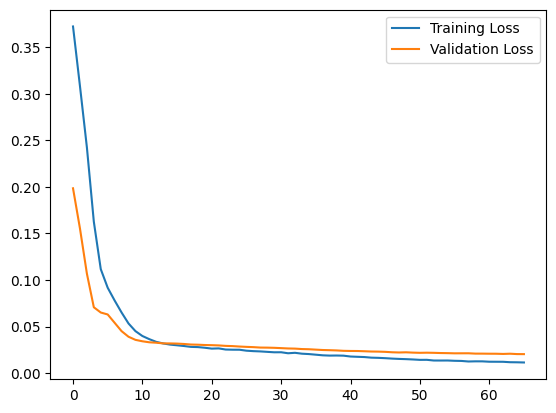

In [16]:
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()

1/1 [==============================] - 0s 69ms/step


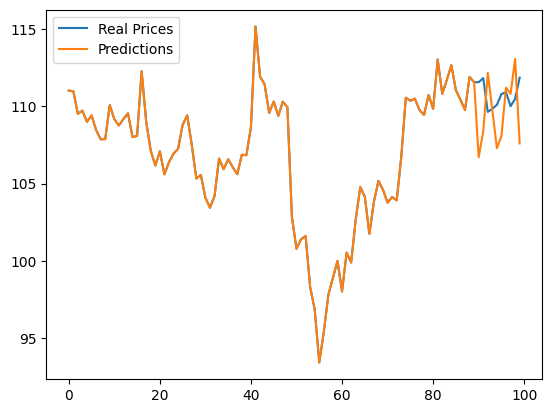

In [17]:
predictions=price_scaler.inverse_transform(model.predict(x[-1].reshape(-1, 32, 32, 1)))
real_closes = price_scaler.inverse_transform(ibm['Close'].values.reshape(-1,1))
plt.plot(real_closes[-100:],label='Real Prices')
plt.plot(np.append(real_closes[-100:-future_pred],predictions),label='Predictions')
plt.legend()

In [18]:
error = mean_squared_error(predictions.reshape(-1,1),real_closes[-future_pred:])
errors['2-D CNN'] = error
error

8.268275882408478

## 1D-CNN

In [19]:
window = 32
x=[]
y=[]
for i in range(window, len(ibm.values)-future_pred):
    x.append(ibm.values[i - window:i, 3])
    y.append(ibm.values[i:i+future_pred, 3])
x = np.array(x).reshape(-1,window)
y = np.array(y).reshape(-1,future_pred)

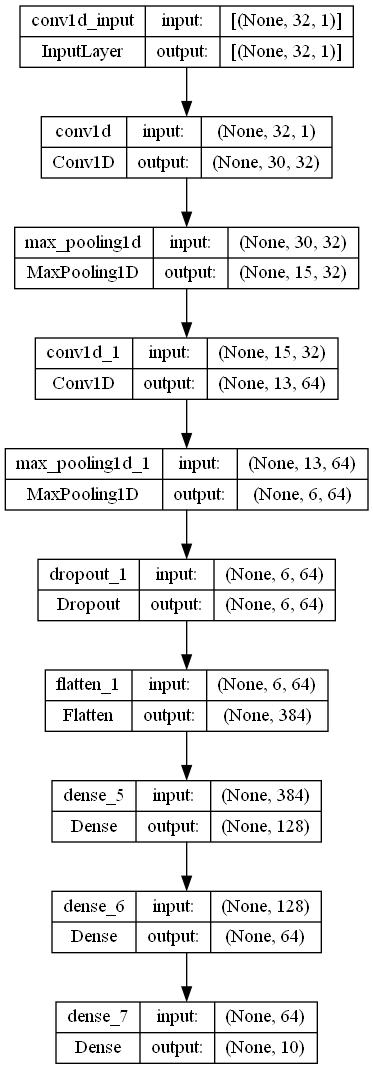

In [20]:
model = Sequential([
    Conv1D(32,3,activation='relu',input_shape=(window,1)),
    MaxPool1D(pool_size=(2)),
    Conv1D(64,3,activation='relu'),
    MaxPool1D(pool_size=(2)),
    Dropout(0.25),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(future_pred)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00002,
),
    loss='mse',
)
plot_model(model, show_shapes=True, to_file='cnn_1d.png')

In [21]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10,min_delta=0.001)
history = model.fit(x[:-1],y[:-1],
                    validation_split = 0.1,
                    epochs=200,
                    shuffle=False,
                    verbose=0,
                    callbacks=[
                        earlystopping,
                    ],
                    workers=-1
                   )

Epoch 15: early stopping


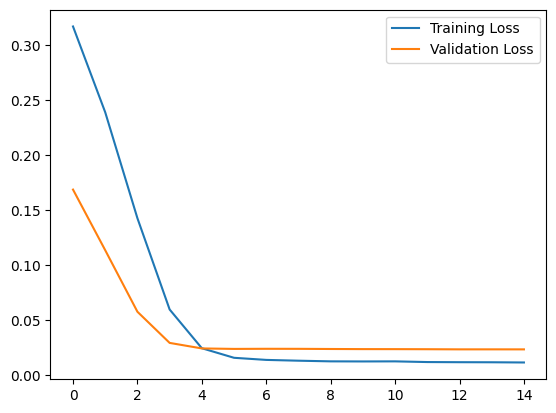

In [22]:
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()

1/1 [==============================] - 0s 84ms/step


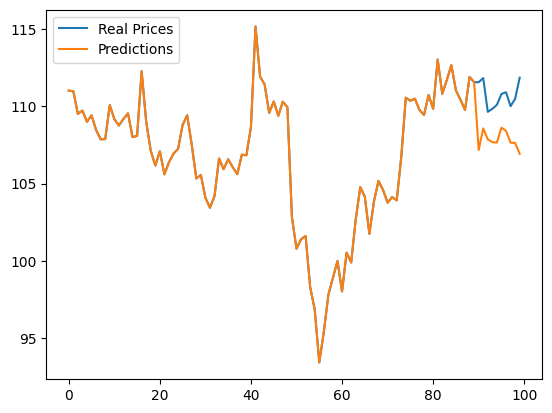

In [23]:
predictions=price_scaler.inverse_transform(model.predict(x[-1].reshape(-1, window)))
real_closes = price_scaler.inverse_transform(ibm['Close'].values.reshape(-1,1))
plt.plot(real_closes[-100:],label='Real Prices')
plt.plot(np.append(real_closes[-100:-future_pred],predictions),label='Predictions')
plt.legend()

In [24]:
error = mean_squared_error(predictions.reshape(-1,1),real_closes[-future_pred:])
errors['1-D CNN'] = error
error

9.272687546565434

## 1D-CNN + LSTM

In [25]:
window = 32
x=[]
y=[]
for i in range(window, len(ibm.values)-future_pred):
    x.append(ibm.values[i - window:i, 3])
    y.append(ibm.values[i:i+future_pred, 3])
x = np.array(x).reshape(-1,window)
y = np.array(y).reshape(-1,future_pred)

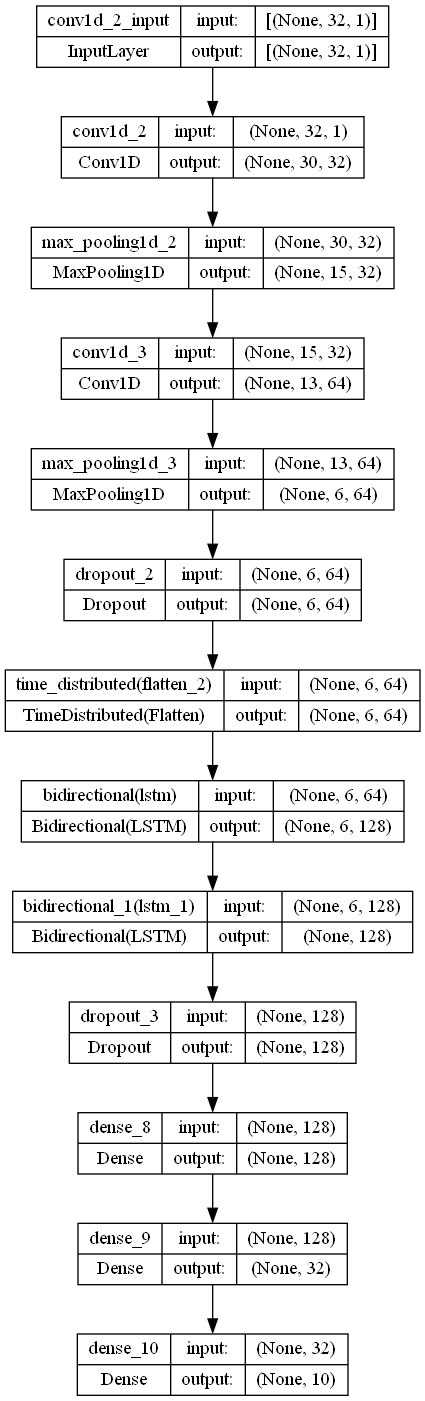

In [26]:
model = Sequential([
    Conv1D(32,3,activation='relu',input_shape=(window,1)),
    MaxPool1D(pool_size=(2)),
    Conv1D(64,3,activation='relu'),
    MaxPool1D(pool_size=(2)),
    Dropout(0.25),
    TimeDistributed(Flatten()),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.25),
    Dense(128,activation='relu'),
    Dense(32,activation='relu'),
    Dense(future_pred)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00002,
),
    loss='mse',
)
plot_model(model, show_shapes=True, to_file='cnn_1d_with_lstm.png')

In [27]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10,min_delta=0.001)
history = model.fit(x[:-1],y[:-1],
                    validation_split = 0.1,
                    epochs=250,
                    shuffle=False,
                    verbose=0,
                    callbacks=[
                        earlystopping,
                    ],
                    workers=-1
                   )

Epoch 32: early stopping


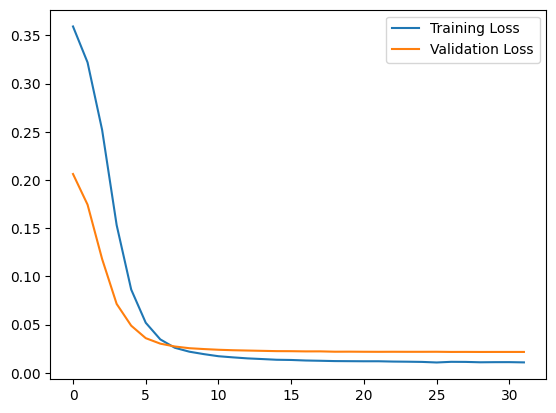

In [28]:
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()

1/1 [==============================] - 1s 1s/step


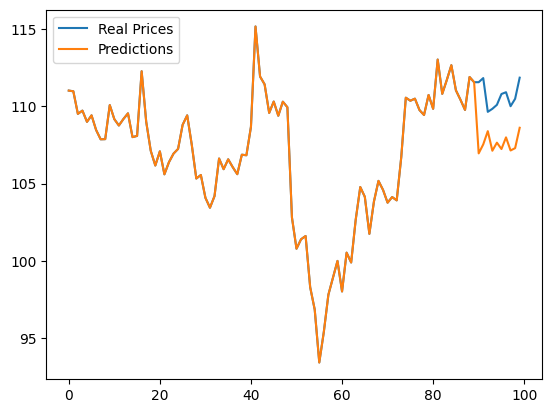

In [29]:
predictions=price_scaler.inverse_transform(model.predict(x[-1].reshape(-1, window)))
real_closes = price_scaler.inverse_transform(ibm['Close'].values.reshape(-1,1))
plt.plot(real_closes[-100:],label='Real Prices')
plt.plot(np.append(real_closes[-100:-future_pred],predictions),label='Predictions')
plt.legend()

In [30]:
error = mean_squared_error(predictions.reshape(-1,1),real_closes[-future_pred:])
errors['1-D CNN + LSTM'] = error
error

10.480417879350721

In [31]:
model.save('best_cnn_1d_with_lstm')

INFO:tensorflow:Assets written to: best_cnn_1d_with_lstm\assets


INFO:tensorflow:Assets written to: best_cnn_1d_with_lstm\assets


## 2D-CNN+ LSTM

In [32]:
x = []
y = []
for i in range(32, len(ibm.values)-future_pred):
    x.append(ibm.values[i - 32:i, 0:ibm.shape[1]])
    y.append(ibm.values[i:i+future_pred, 3])

x , y = np.array(x),np.array(y)

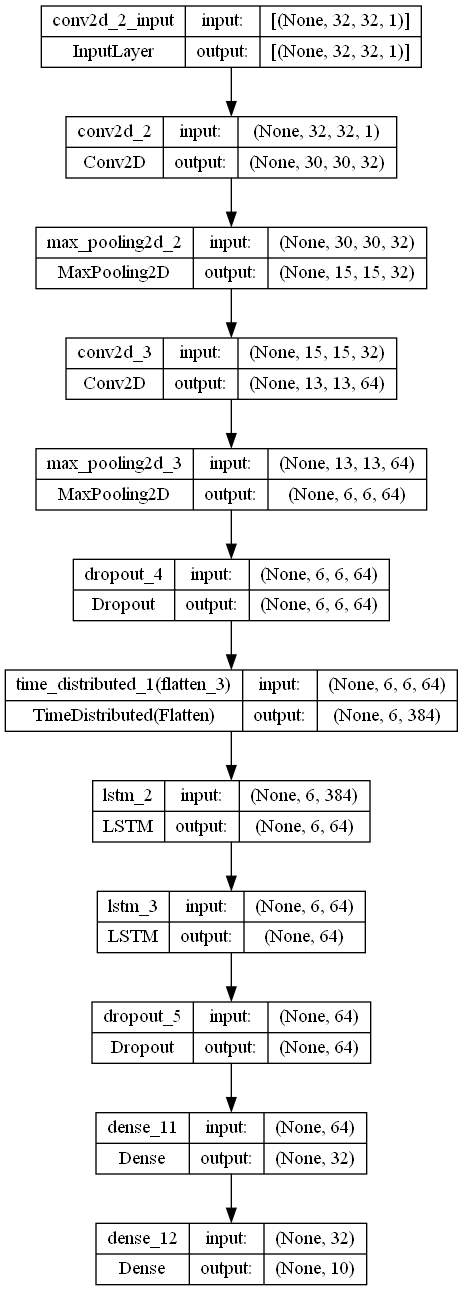

In [33]:
model = Sequential([
    Conv2D(32,3,activation='relu',input_shape=(x.shape[1],x.shape[2],1)),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(64,3,activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=False),
    Dropout(0.25),
    Dense(32,activation='relu'),
    Dense(future_pred)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00002,
),
    loss='mse',
)
plot_model(model, show_shapes=True, to_file='cnn_2d_with_lstm.png')

In [34]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5,min_delta=0.001)
history = model.fit(x[:-1],y[:-1],
                    validation_split = 0.1,
                    epochs=150,
                    shuffle=False,
                    verbose=0,
                    workers=-1,
                    callbacks=[
                        earlystopping,
                    ],
                   )

Epoch 21: early stopping


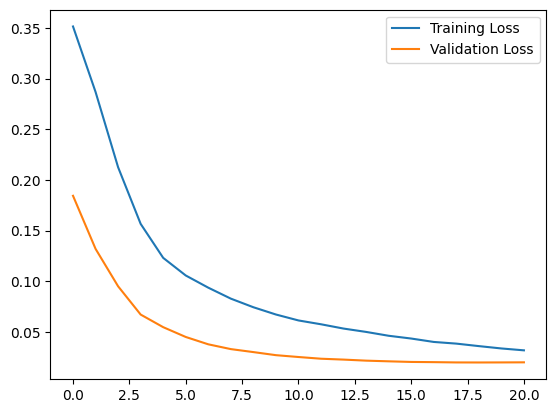

In [35]:
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()

1/1 [==============================] - 1s 713ms/step


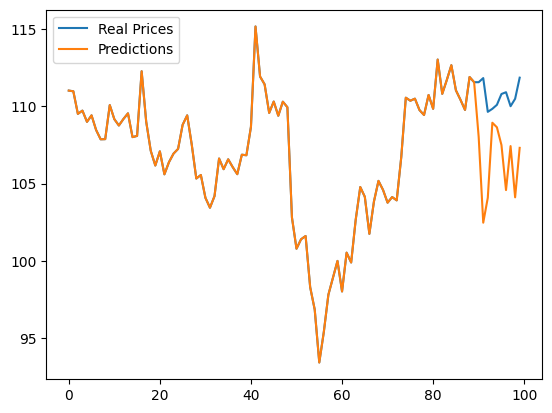

In [36]:
predictions=price_scaler.inverse_transform(model.predict(x[-1].reshape(-1, 32, 32, 1)))
real_closes = price_scaler.inverse_transform(ibm['Close'].values.reshape(-1,1))
plt.plot(real_closes[-100:],label='Real Prices')
plt.plot(np.append(real_closes[-100:-future_pred],predictions),label='Predictions')
plt.legend()

In [37]:
error = mean_squared_error(predictions.reshape(-1,1),real_closes[-future_pred:])
errors['2-D CNN + LSTM'] = error
error

25.324597362440528

In [38]:
model.save('best_cnn_2d_with_lstm')

INFO:tensorflow:Assets written to: best_cnn_2d_with_lstm\assets


INFO:tensorflow:Assets written to: best_cnn_2d_with_lstm\assets


## Inception

In [39]:
x = []
y = []
for i in range(32, len(ibm.values)-future_pred):
    x.append(ibm.values[i - 32:i, 0:ibm.shape[1]])
    y.append(ibm.values[i:i+future_pred, 3])
x , y = np.array(x),np.array(y)

In [40]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)

    conv3 = Conv2D(f2_in,1, activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, 3, padding='same',activation='relu')(conv3)

    conv5 = Conv2D(f3_in, 1, activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, 5, padding='same',activation='relu')(conv5)

    pool = MaxPool2D(2, strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, 1, activation='relu')(pool)

    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [41]:
input_layer = Input(shape=(x.shape[1],x.shape[2],1))

layer = inception_module(input_layer, 64, 64, 128, 16, 32, 32)
layer = inception_module(layer, 64, 64, 128, 16, 32, 32)
output = Flatten()(layer)
output = Dense(512)(output)
output = Dropout(0.25)(output)
output = Dense(128)(output)
output = Dense(future_pred)(output)
model = Model(inputs=input_layer, outputs=output)

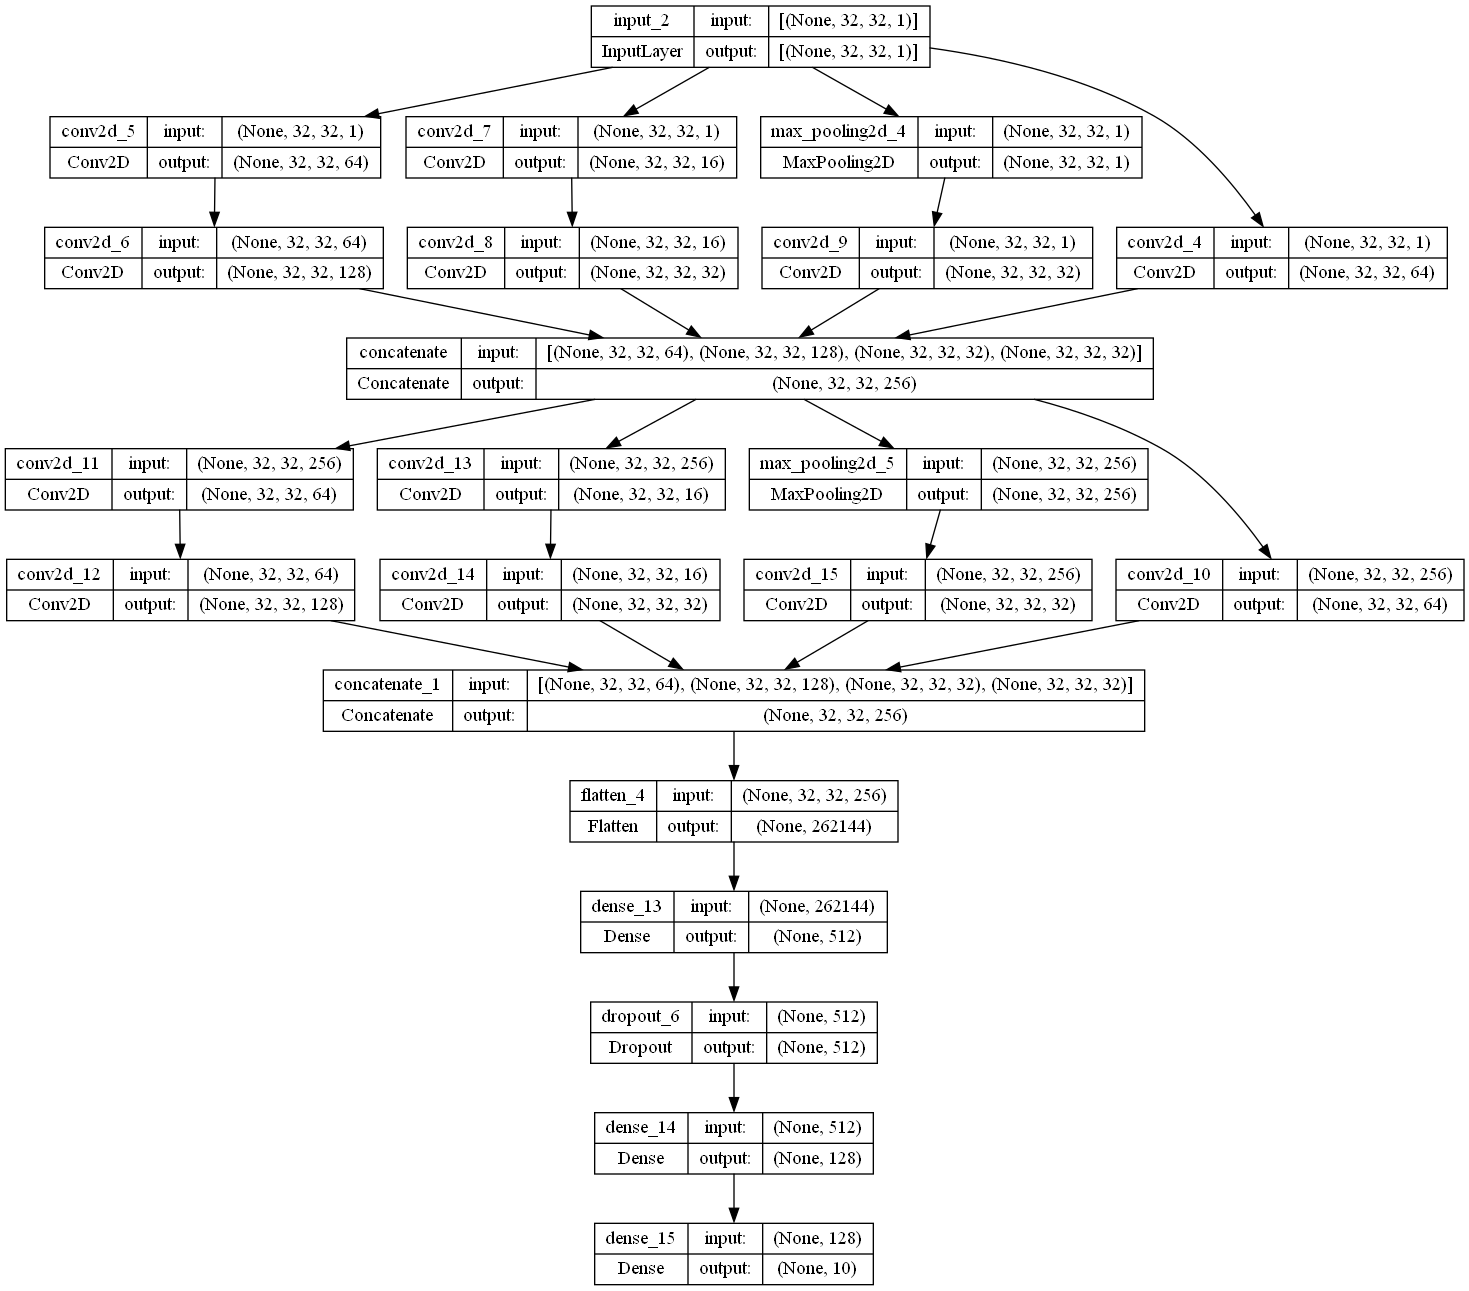

In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
       learning_rate=0.00001,
),
    loss='mse',
)
plot_model(model, show_shapes=True, to_file='inception_module.png')

In [43]:
checkpoint = ModelCheckpoint(
    filepath='best_inception',
    save_best_only=True,
    verbose=1, 
)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5,min_delta=0.001)
history = model.fit(x[:-1],y[:-1],
                    validation_split = 0.1,
                    epochs=150,
                    shuffle=False,
                    verbose=0,
                    workers=-1,
                    callbacks=[
#                         checkpoint,
                        earlystopping
                    ],
                   )

Epoch 8: early stopping


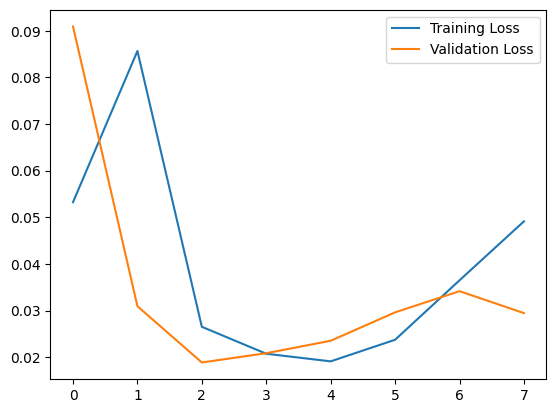

In [44]:
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()

1/1 [==============================] - 0s 438ms/step


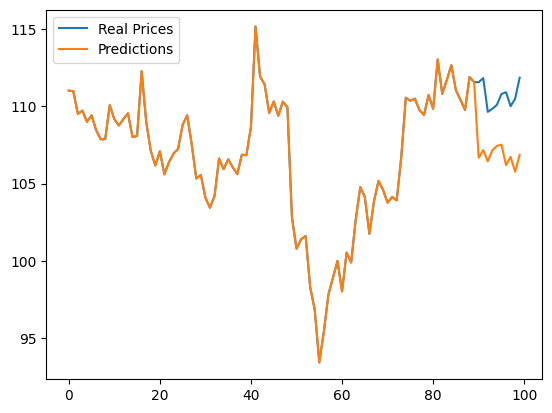

In [65]:
model = load_model('best_inception')
predictions=price_scaler.inverse_transform(model.predict(x[-1].reshape(-1, 32, 32, 1)))
real_closes = price_scaler.inverse_transform(ibm['Close'].values.reshape(-1,1))
plt.plot(real_closes[-100:],label='Real Prices')
plt.plot(np.append(real_closes[-100:-future_pred],predictions),label='Predictions')
error = mean_squared_error(predictions.reshape(-1,1),real_closes[-future_pred:])
errors['Inception'] = error
plt.legend()

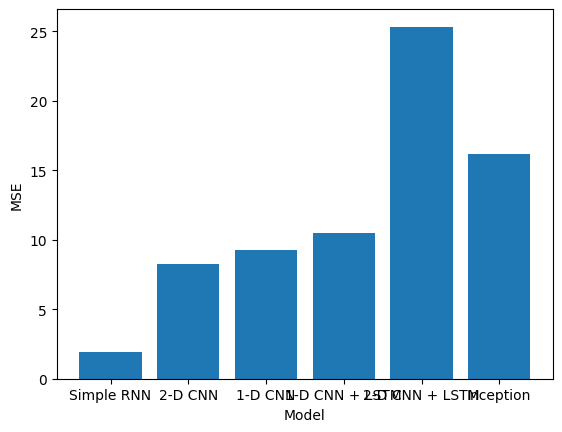

In [64]:
plt.bar(
    range(len(errors)),
    list(errors.values()),
    tick_label=list(errors.keys()))
plt.xlabel("Model")
plt.ylabel("MSE")
plt.show()